In [63]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import os

os.chdir('/Users/quinnmackay/Documents/GitHub/BICC/Data Storage/NGRIP/Density files')

In [64]:
shallow_min = 0
bridge_min = 11
central_min = 13
bridge2_min = 97.5
end_min = 107.5
extrap_min = 625

In [65]:
#importing

#JP Legacy GRIP Shallow Core
grip1 = pd.read_csv('/Users/quinnmackay/Documents/GitHub/BICC/Data Storage/GRIP/GRIP1991shallow_density.txt',skiprows=6, header=None)
grip1.rename(columns={0: 'depth'}, inplace=True)
grip1.rename(columns={1: 'density'}, inplace=True)

#Jakob Spline Fit
ngrip1 = pd.read_csv('ng1mbp01.txt',skiprows=26, sep=r'\s+')
ngrip1.rename(columns={'DEPTH(m)': 'depth'}, inplace=True)
ngrip1.rename(columns={'Density': 'density'}, inplace=True)

#NGRIP1 Main Core
ngrip2 = pd.read_excel('NG96DEN.xls',skiprows=6, usecols=[3,6])
ngrip2.rename(columns={'Depth at bottom of bag (m)': 'depth'}, inplace=True)
ngrip2.rename(columns={'Density of bag (kg/m3)': 'density'}, inplace=True)

#2001 Shallow Core
ngrip3 = pd.read_csv('NGRIP_2001_S5_density.txt', skiprows=2, delimiter='\t')

#S4 from Dr. Kawamura
ngrip4 = pd.read_excel('firn data NGRIP2001/NGRPdens.xls', sheet_name=0, skiprows=5, header=None, usecols=[0,5])
ngrip4.rename(columns={0: 'depth'}, inplace=True)
ngrip4.rename(columns={5: 'density'}, inplace=True)

#S5 from Dr. Kawamura
ngrip5 = pd.read_excel('firn data NGRIP2001/NGRPdens.xls', sheet_name=1, skiprows=4, header=None, usecols=[0,5])
ngrip5.rename(columns={0: 'depth'}, inplace=True)
ngrip5.rename(columns={5: 'density'}, inplace=True)

#Kenji S2? Using MEAN depth
ngrip6 = pd.read_excel('NG97S2Density.xlsx', sheet_name=0, skiprows=2, usecols=[3,11], header=None)
ngrip6.rename(columns={3: 'depth'}, inplace=True)
ngrip6.rename(columns={11: 'density'}, inplace=True)
ngrip6

/opt/miniconda3/envs/bicc/lib/python3.13/site-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


,depth,density
0,1.79000,0.346096
1,2.42500,0.345778
2,2.90650,0.384213
3,3.26650,0.367351
4,3.72150,0.372722
...,...,...
244,138.08300,0.895170
245,138.23100,0.880701
246,138.43275,0.891083
247,138.61475,0.888203


Text(0, 0.5, 'Relative Density')

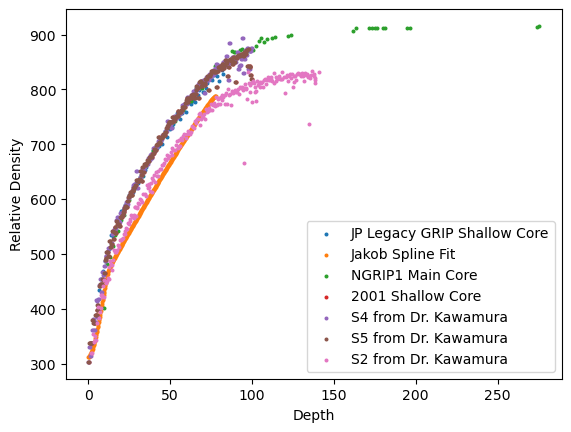

In [66]:
#creating plot

ice_dens = 921
size=3.5

plt.scatter(grip1['depth'], grip1['density'], label="JP Legacy GRIP Shallow Core", s=size)
plt.scatter(ngrip1['depth'], ngrip1['density']*ice_dens, label='Jakob Spline Fit', s=size)
plt.scatter(ngrip2['depth'], ngrip2['density'], label='NGRIP1 Main Core', s=size)
plt.scatter(ngrip3['depth'], ngrip3['density'], label='2001 Shallow Core', s=size)
plt.scatter(ngrip4['depth'], ngrip4['density'], label='S4 from Dr. Kawamura', s=size)
plt.scatter(ngrip5['depth'], ngrip5['density'], label='S5 from Dr. Kawamura', s=size)
plt.scatter(ngrip6['depth'], ngrip6['density']*ice_dens, label='S2 from Dr. Kawamura', s=size)

plt.legend()
plt.xlabel('Depth')
plt.ylabel('Relative Density')
#plt.xlim(25,40)
#plt.ylim(0.3,0.8)

In [67]:
#manually trim positive outliers

ngrip4 = pd.read_excel('firn data NGRIP2001/NGRPdens.xls', sheet_name=0, skiprows=5, header=None, usecols=[0,5])
ngrip4.rename(columns={0: 'depth'}, inplace=True)
ngrip4.rename(columns={5: 'density'}, inplace=True)

indexes = [312,313,342,343,106,107]
ngrip4['density'][indexes] = np.nan

ngrip4 = ngrip4.dropna(subset=['density'])
ngrip4 = ngrip4.reset_index(drop=True)

/var/folders/cd/1mh45k3j19g5g_kxkz_17xvc0000gn/T/ipykernel_7157/2812083537.py:8: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ngrip4['density'][indexes] = np.nan


In [68]:
#let's go by 0.2 at a time and filter out low data by a 5 density constraint

#0.2 spacing
intervals = np.arange(0,125.2+0.2,0.15)

dfs = [grip1, ngrip2, ngrip3, ngrip4, ngrip5]
combined_data = pd.concat(dfs, ignore_index=True)

#organize
combined_data = combined_data.sort_values(by='depth', ascending=True)

for i in range(len(intervals)):
    if i == 0:
        continue
    mask = (combined_data['depth'] < intervals[i]) & (combined_data['depth'] >= intervals[i - 1])
    maximum_val = np.max(combined_data[mask]['density'])
    if pd.isna(maximum_val):
        continue
    minimum_allowed = maximum_val - 5

    combined_mask = mask & (combined_data['density'] < minimum_allowed)
    combined_data.loc[combined_mask, 'density'] = np.nan

    combined_data = combined_data.dropna(subset=['density'])



(0.0, 100.0)

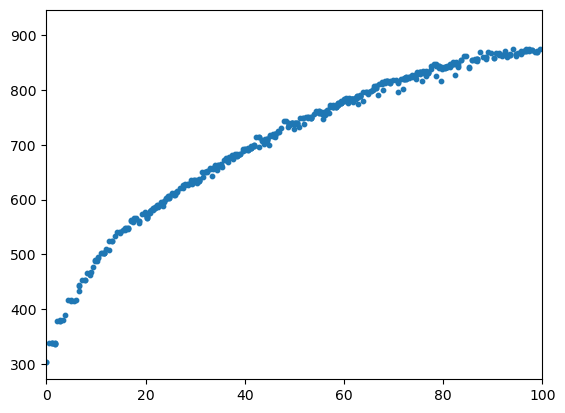

In [69]:
#plot for visualizing sections

#combined_data = pd.concat(dfs, ignore_index=True)
plt.scatter(combined_data['depth'], combined_data['density'], s=10)
plt.xlim(0,100)
#plt.ylim(450,600)

In [70]:
from numpy import polyfit, poly1d

#linear shallow section
mask = (combined_data['depth']>shallow_min) & (combined_data['depth']<=bridge_min)
z_shallow = combined_data['depth'][mask]
rho_shallow = combined_data['density'][mask]
p_shallow = polyfit(z_shallow, rho_shallow, 1)  # linear
rho_fit_shallow = poly1d(p_shallow)


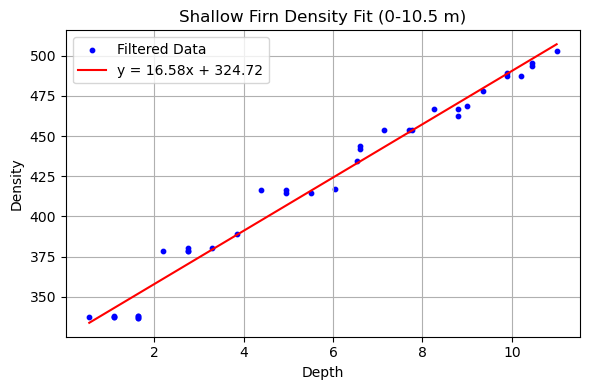

In [71]:
#shallow plot

plt.figure(figsize=(6, 4))
plt.scatter(z_shallow, rho_shallow, label='Filtered Data', color='blue', s=10)
plt.plot(z_shallow, rho_fit_shallow(z_shallow), label=f'y = {np.round(p_shallow[0],2)}x + {np.round(p_shallow[1],2)}', color='red')
plt.xlabel('Depth')
plt.ylabel('Density')
plt.title('Shallow Firn Density Fit (0-10.5 m)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [72]:
#central section
mask = (combined_data['depth']>central_min) & (combined_data['depth']<=bridge2_min)
z_central = combined_data['depth'][mask]
rho_central = combined_data['density'][mask]
p_central = polyfit(z_central, rho_central, 3)  # linear
rho_fit_central = poly1d(p_central)

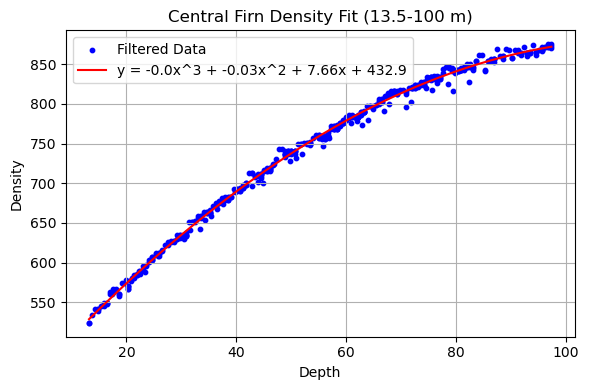

In [73]:
plt.figure(figsize=(6, 4))
plt.scatter(z_central, rho_central, label='Filtered Data', color='blue', s=10)
plt.plot(z_central, rho_fit_central(z_central), label=f'y = {np.round(p_central[0],2)}x^3 + {np.round(p_central[1],2)}x^2 + {np.round(p_central[2],2)}x + {np.round(p_central[3],2)}', color='red')
plt.xlabel('Depth')
plt.ylabel('Density')
plt.title('Central Firn Density Fit (13.5-100 m)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [74]:
#bridge section

from numpy.linalg import solve

#boundaries
z1 = bridge_min
z2 = central_min

# Get function values and derivatives at z1 and z2
y1 = rho_fit_shallow(z1)
y2 = rho_fit_central(z2)

dy1 = np.polyder(rho_fit_shallow)(z1)
dy2 = np.polyder(rho_fit_central)(z2)

#create bidge polynomial
A = np.array([
    [z1**3, z1**2, z1, 1],
    [z2**3, z2**2, z2, 1],
    [3*z1**2, 2*z1, 1, 0],
    [3*z2**2, 2*z2, 1, 0]
])
b = np.array([y1, y2, dy1, dy2])

# Solve for cubic coefficients
p_bridge = solve(A, b)
rho_fit_bridge = poly1d(p_bridge)

mask = (combined_data['depth']>bridge_min) & (combined_data['depth']<=central_min)
z_bridge = combined_data['depth'][mask]

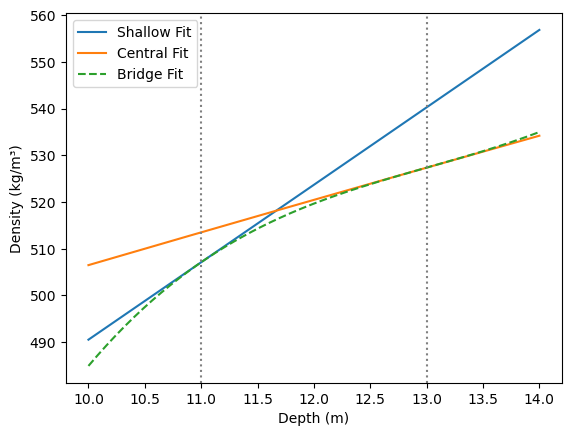

In [75]:
#check fit

z_vals = np.linspace(bridge_min-1, central_min+1, 200)
plt.plot(z_vals, rho_fit_shallow(z_vals), label='Shallow Fit')
plt.plot(z_vals, rho_fit_central(z_vals), label='Central Fit')
plt.plot(z_vals, rho_fit_bridge(z_vals), label='Bridge Fit', linestyle='--')

plt.axvline(z1, color='gray', linestyle=':')
plt.axvline(z2, color='gray', linestyle=':')
plt.xlabel("Depth (m)")
plt.ylabel("Density (kg/m³)")
plt.legend()
plt.show()

In [76]:
###deep section

def rho_deep_model(z, k1, k2):
    return 921 - k1 / (z - k2)

mask = (combined_data['depth']>bridge2_min)
z_deep = combined_data['depth'][mask]
rho_deep = combined_data['density'][mask]

from scipy.optimize import curve_fit

# Initial guess for k1 and k2
initial_guess = [1400, 50]

params, _ = curve_fit(rho_deep_model, z_deep, rho_deep, p0=initial_guess)
k1_fit, k2_fit = params

print(f"Fitted parameters: k1 = {k1_fit:.2f}, k2 = {k2_fit:.3f}")

def rho_fit_deep(z):
    return rho_deep_model(z, k1_fit, k2_fit)

Fitted parameters: k1 = 859.97, k2 = 81.107


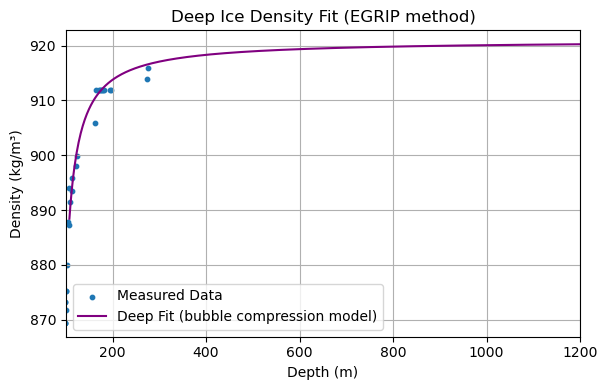

In [77]:
z_plot = np.linspace(end_min, 1200, 500)

plt.figure(figsize=(6, 4))
plt.scatter(z_deep, rho_deep, label="Measured Data", s=10)
plt.plot(z_plot, rho_fit_deep(z_plot), color="purple", label="Deep Fit (bubble compression model)")

plt.xlabel("Depth (m)")
plt.ylabel("Density (kg/m³)")
plt.title("Deep Ice Density Fit (EGRIP method)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xlim(100,1200)
plt.show()

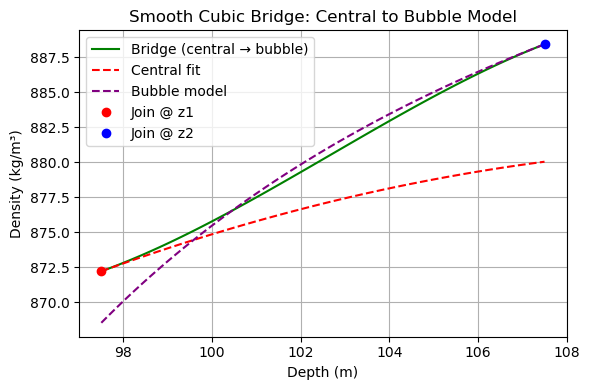

In [78]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import solve
from numpy import poly1d, polyder

# --- Inputs ---
# Your fitted central polynomial (poly1d)
# Your bubble model parameters (k1, k2 from earlier)
# Join depths
z1 = bridge2_min  # end of central
z2 = end_min  # start of bubble

# --- Central fit ---
y1 = rho_fit_central(z1)
dy1 = polyder(rho_fit_central)(z1)

# --- Bubble model ---
def rho_fit_bubble(z):
    return 921 - k1_fit / (z - k2_fit)

def drho_fit_bubble(z):
    return k1_fit / (z - k2_fit)**2

y2 = rho_fit_bubble(z2)
dy2 = drho_fit_bubble(z2)

# --- Solve for cubic bridge coefficients ---
A = np.array([
    [z1**3, z1**2, z1, 1],
    [z2**3, z2**2, z2, 1],
    [3*z1**2, 2*z1, 1, 0],
    [3*z2**2, 2*z2, 1, 0]
])
b = np.array([y1, y2, dy1, dy2])
p_c2b = solve(A, b)
rho_fit_c2b = poly1d(p_c2b)

# --- Evaluate bridge and plot ---
z_bridge = np.linspace(z1, z2, 100)

plt.figure(figsize=(6, 4))
plt.plot(z_bridge, rho_fit_c2b(z_bridge), color="green", label="Bridge (central → bubble)")
plt.plot(z_bridge, rho_fit_central(z_bridge), '--', color="red", label="Central fit")
plt.plot(z_bridge, rho_fit_bubble(z_bridge), '--', color="purple", label="Bubble model")
plt.plot([z1], [y1], 'ro', label="Join @ z1")
plt.plot([z2], [y2], 'bo', label="Join @ z2")

plt.xlabel("Depth (m)")
plt.ylabel("Density (kg/m³)")
plt.title("Smooth Cubic Bridge: Central to Bubble Model")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


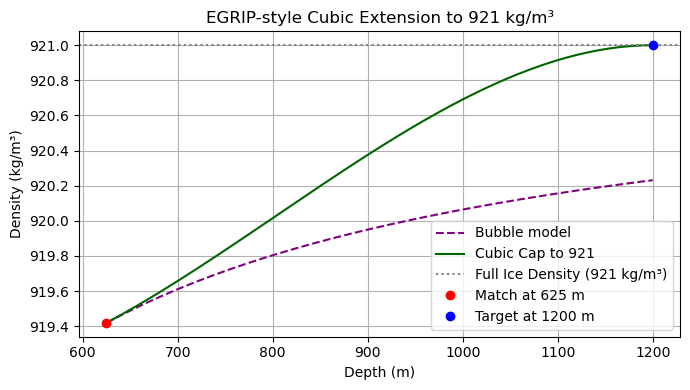

In [79]:
z1 = 625   # join point
z2 = 1200  # where density must reach 921 with zero slope

# --- Parameters from your bubble fit ---
# Use your previously fitted k1_fit and k2_fit
k1 = k1_fit
k2 = k2_fit

# --- Define model and derivative ---
def rho_fit_bubble(z):
    return 921 - k1 / (z - k2)

def drho_fit_bubble(z):
    return k1 / (z - k2)**2

y1 = rho_fit_bubble(z1)
dy1 = drho_fit_bubble(z1)
y2 = 921
dy2 = 0  # slope must be 0 at 1200 m

# --- Solve cubic: a*z^3 + b*z^2 + c*z + d ---
A = np.array([
    [z1**3, z1**2, z1, 1],
    [z2**3, z2**2, z2, 1],
    [3*z1**2, 2*z1, 1, 0],
    [3*z2**2, 2*z2, 1, 0]
])
b = np.array([y1, y2, dy1, dy2])

# Solve for polynomial coefficients
p_deep_cap = solve(A, b)
rho_fit_deep_cap = poly1d(p_deep_cap)

# --- Plot ---
z_cap = np.linspace(z1, z2, 200)

plt.figure(figsize=(7, 4))
plt.plot(z_cap, rho_fit_bubble(z_cap), '--', label='Bubble model', color='purple')
plt.plot(z_cap, rho_fit_deep_cap(z_cap), label='Cubic Cap to 921', color='darkgreen')
plt.axhline(921, color='gray', linestyle=':', label='Full Ice Density (921 kg/m³)')
plt.plot([z1], [y1], 'ro', label=f'Match at {z1} m')
plt.plot([z2], [y2], 'bo', label='Target at 1200 m')

plt.xlabel("Depth (m)")
plt.ylabel("Density (kg/m³)")
plt.title("EGRIP-style Cubic Extension to 921 kg/m³")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


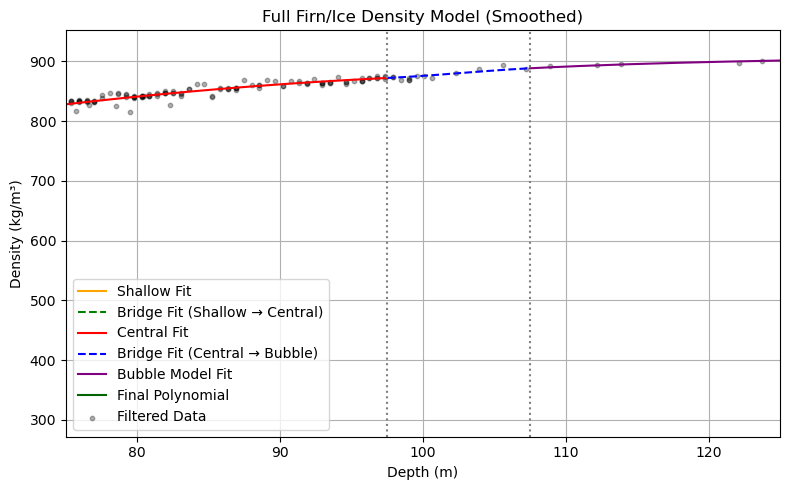

In [ ]:
plt.figure(figsize=(8, 5))

# Depth ranges
z_shallow = np.linspace(shallow_min, bridge_min, 200)
z_bridge = np.linspace(bridge_min, central_min, 100)
z_central = np.linspace(central_min, bridge2_min, 300)
z_bridge2 = np.linspace(bridge2_min, end_min, 100)
z_deep = np.linspace(end_min, extrap_min, 300)
z_extrap = np.linspace(extrap_min, 1200, 300)

# Plot full composite model
plt.plot(z_shallow, rho_fit_shallow(z_shallow), label='Shallow Fit', color='orange')
plt.plot(z_bridge, rho_fit_bridge(z_bridge), label='Bridge Fit (Shallow → Central)', linestyle='--', color='green')
plt.plot(z_central, rho_fit_central(z_central), label='Central Fit', color='red')
plt.plot(z_bridge2, rho_fit_c2b(z_bridge2), label='Bridge Fit (Central → Bubble)', linestyle='--', color='blue')
plt.plot(z_deep, rho_fit_deep(z_deep), label='Bubble Model Fit', color='purple')
plt.plot(z_extrap, rho_fit_deep_cap(z_extrap), label='Final Polynomial', color='darkgreen')

# Raw data
plt.scatter(combined_data['depth'], combined_data['density'], label='Filtered Data', color='black', s=10, alpha=0.3)

# Annotations
plt.axvline(bridge_min, color='gray', linestyle=':')
plt.axvline(central_min, color='gray', linestyle=':')
plt.axvline(bridge2_min, color='gray', linestyle=':')
plt.axvline(end_min, color='gray', linestyle=':')

plt.xlabel('Depth (m)')
plt.ylabel('Density (kg/m³)')
plt.title('Full Firn/Ice Density Model (Smoothed)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [97]:
#create dataset

# Depth ranges
#let's make it so there is 1 datapoint for each ~0.2
z_shallow = np.linspace(shallow_min, bridge_min, int((bridge_min-shallow_min)*5))
z_bridge = np.linspace(bridge_min, central_min, int((central_min-bridge_min)*5))
z_central = np.linspace(central_min, bridge2_min, int((bridge2_min-central_min)*5))
z_bridge2 = np.linspace(bridge2_min, end_min, int((end_min-bridge2_min)*5))
z_deep = np.linspace(end_min, extrap_min, int((extrap_min-end_min)*5))
z_extrap = np.linspace(extrap_min, 1200, int((1200-extrap_min)*5))

#rho_vals
rho_shallow = rho_fit_shallow(z_shallow)
rho_bridge = rho_fit_bridge(z_bridge)
rho_central = rho_fit_central(z_central)
rho_bridge2 = rho_fit_c2b(z_bridge2)
rho_deep = rho_fit_deep(z_deep)
rho_extrap = rho_fit_deep_cap(z_extrap)

z_all = np.concatenate((z_shallow, z_bridge, z_central, z_bridge2, z_deep, z_extrap))
rho_all = np.concatenate((rho_shallow, rho_bridge, rho_central, rho_bridge2, rho_deep, rho_extrap))

final_output = pd.DataFrame({
    'depth': z_all,
    'density': rho_all
})

final_output = final_output.sort_values(by='depth', ascending=True)


In [98]:
final_output

,depth,density
0,0.000000,324.720361
1,0.203704,328.097822
2,0.407407,331.475284
3,0.611111,334.852746
4,0.814815,338.230208
...,...,...
5994,1199.199722,920.999994
5995,1199.399791,920.999997
5996,1199.599861,920.999999
5997,1199.799930,921.000000
